In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from pathlib import Path
from os import listdir
from itertools import product
from IPython.display import display, Markdown, Latex

In [68]:
BASE_DIR = Path("../log")
BASE_DIR_SAMU = Path("../log_samu")
BASE_DIR_SECOND = Path('../log_second_try')
BASE_DIR_SECOND_SAMU = Path('../log_second_try_samu')

In [69]:
PROCESSES=[1, 4, 8, 16, 32, 64]
THREADS=[1, 8, 16, 32]
SELECT=[1, 2, 3, 4, 5]
PLACES=['pack', 'scatter', 'pack:excl', 'scatter:excl']

In [70]:
def process_log_dir(d):
    files = sorted(listdir(d))
    err_files = list(filter(lambda x: "err" in x, files))
    out_files = list(filter(lambda x: "out" in x, files))
    err_files = list(map(lambda x: d / x, err_files))
    out_files = list(map(lambda x: d / x, out_files))
    outs = list(map(lambda x: process_out(x), out_files))
    errs = list(map(lambda x: process_err(x), err_files))
    samples = []
    for o, e in zip(outs, errs):
        for i in range(4):
            assert o[i] == e[i], print(o, e, "There is a mismatch in the output and error files")
        samples.append(o + [e[-1]])
    return samples

def process_out(filepath):
    tmp = filepath.name.split("-")
    processes, threads, place, packs = tmp[1:]
    fitness = []
    time = []
    with open(filepath) as f:
        for line in f:
            if "Execution time" in line:
                time.append(float(line.split(" ")[-1]))
            elif "Best fitness" in line:
                fitness.append(float(line.split(" ")[-1]))
    fitness = min(fitness) if len(fitness) > 0 else np.nan
    time = sum(time) / len(time) if len(time) > 0 else np.nan
    return [int(processes), int(threads), place, int(packs), fitness, time]
def process_err(filepath):
    tmp = filepath.name.split("-")
    processes, threads, place, packs = tmp[1:]
    time = np.nan
    with open(filepath) as f:
        for line in f:
            if 'real' in line:
                tmp = line.split("\t")[-1]
                tmp = tmp.split("m")
                minutes, seconds = float(tmp[0]), float(tmp[1][:-2])
                time = minutes * 60 + seconds
            elif 'job killed' in line:
                time = -1
    return [int(processes), int(threads), place, int(packs), time]
def create_id(x):
    return f"{str(x.processes)}--{str(x.threads)}--{x.place}--{x.packs}"
def create_id_from_tuple(x):
    return f"{str(x[0])}--{str(x[1])}--{x[2]}--{x[3]}"
def mean_time(x):
    return np.nanmean([x.internal_time_fede, x.internal_time_samu])

In [71]:
all_run_names = list(product(PROCESSES, THREADS, PLACES, SELECT))

In [72]:
runs_fede = pd.DataFrame(process_log_dir(BASE_DIR), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])
runs_samu = pd.DataFrame(process_log_dir(BASE_DIR_SAMU), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])
runs_fede_second = pd.DataFrame(process_log_dir(BASE_DIR_SECOND), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])
runs_samu_second = pd.DataFrame(process_log_dir(BASE_DIR_SECOND_SAMU), columns=['processes', 'threads', 'place', 'packs', 'fitness', 'internal_time', 'external_time'])

In [73]:
runs_fede['id'] = runs_fede.apply(create_id, axis=1)
runs_fede = runs_fede.drop(columns=['threads', 'processes', 'place', 'packs'])
runs_samu['id'] = runs_samu.apply(create_id, axis=1)
runs_samu = runs_samu.drop(columns=['threads', 'processes', 'place', 'packs'])
runs = runs_fede.merge(
    runs_samu,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs['internal_time'] = runs.apply(mean_time, axis=1)
runs['processes'] = runs.id.apply(lambda x: int(x.split("--")[0]))
runs['threads'] = runs.id.apply(lambda x: int(x.split("--")[1]))
runs['place'] = runs.id.apply(lambda x: x.split("--")[2])
runs['packs'] = runs.id.apply(lambda x: int(x.split("--")[3]))

total_runs = len(runs)
total_runs

/tmp/ipykernel_9166/3558000580.py:49: RuntimeWarning: Mean of empty slice
  return np.nanmean([x.internal_time_fede, x.internal_time_samu])


869

In [74]:
runs_samu_second['processes'] = runs_samu_second.processes * runs_samu_second.packs
runs_fede_second['processes'] = runs_fede_second.processes * runs_fede_second.packs
runs_fede_second['id'] = runs_fede_second.apply(create_id, axis=1)
runs_fede_second = runs_fede_second.drop(columns=['threads', 'processes', 'place', 'packs'])
runs_samu_second['id'] = runs_samu_second.apply(create_id, axis=1)
runs_samu_second = runs_samu_second.drop(columns=['threads', 'processes', 'place', 'packs'])
runs_second = runs_fede_second.merge(
    runs_samu_second,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs_second['internal_time'] = runs_second.apply(mean_time, axis=1)
runs_second['processes'] = runs_second.id.apply(lambda x: int(x.split("--")[0]))
runs_second['threads'] = runs_second.id.apply(lambda x: int(x.split("--")[1]))
runs_second['place'] = runs_second.id.apply(lambda x: x.split("--")[2])
runs_second['packs'] = runs_second.id.apply(lambda x: int(x.split("--")[3]))

/tmp/ipykernel_9166/3558000580.py:49: RuntimeWarning: Mean of empty slice
  return np.nanmean([x.internal_time_fede, x.internal_time_samu])


In [75]:
runs = pd.concat([runs, runs_second])
total_runs = len(runs)
total_runs

1253

In [76]:
runs

,fitness_fede,internal_time_fede,external_time_fede,id,fitness_samu,internal_time_samu,external_time_samu,internal_time,processes,threads,place,packs
0,3795.239492,5537.152582,5547.935,1--1--pack--1,NaN,NaN,-1.000,5537.152582,1,1,pack,1
1,3795.239492,5155.176323,5156.062,1--1--pack--2,3795.239492,5246.066370,5246.749,5200.621347,1,1,pack,2
2,3795.239492,5119.717694,5122.271,1--1--pack--3,3795.239492,5675.438444,5677.928,5397.578069,1,1,pack,3
3,3795.239492,4969.297061,4972.338,1--1--pack--4,3795.239492,5072.032511,5073.807,5020.664786,1,1,pack,4
4,3795.239492,5204.252039,5205.286,1--1--pack--5,3795.239492,5051.488734,5055.344,5127.870386,1,1,pack,5
...,...,...,...,...,...,...,...,...,...,...,...,...
379,NaN,NaN,NaN,20--8--pack--5,NaN,NaN,-1.000,NaN,20,8,pack,5
380,NaN,NaN,NaN,40--1--pack--5,5848.436002,130.113625,246.684,130.113625,40,1,pack,5
381,NaN,NaN,NaN,32--1--scatter_excl--4,NaN,NaN,-1.000,NaN,32,1,scatter_excl,4
382,NaN,NaN,NaN,32--16--scatter_excl--4,NaN,NaN,-1.000,NaN,32,16,scatter_excl,4


## Failed runs table

In [285]:
temp = runs[['internal_time_samu', 'internal_time_fede', 'processes', 'threads']]
failed_table = []
#print("| Processes | Threads  |Runs      | Failed   |")
#print("|-----------|----------|----------|----------|")

for p in sorted(list(temp.processes.unique())):
    #print("| Processes | Threads  |Runs      | Failed   |")
    #print("|-----------|----------|----------|----------|")
    for t in sorted(list(temp.threads.unique())):
        a = temp[(temp.processes == p) & (temp.threads == t)]
        a = a[((a.internal_time_fede.isnull())&(a.internal_time_samu.isnull()))]
        #print(f"|{p:<11}|{t:<10}|{len(temp[temp.processes == p]):<10}|{len(a):<10}|")
        failed_table.append([p, t, len(temp[(temp.processes == p) & (temp.threads == t)]), len(a)])
    #print()
failed_table = pd.DataFrame(failed_table, columns=['Processes', 'Threads', 'Runs', 'Failed']).drop(columns='Runs')

In [288]:
failed_table

Threads,Processes,1 threads,2 threads,4 threads,8 threads,16 threads,32 threads,64 threads
0,1,0,0,0,0,3,9,11
1,2,10,7,8,10,11,17,15
3,4,10,8,8,10,13,23,16
5,8,10,8,8,9,19,26,15
7,16,11,7,7,12,29,30,17
10,32,11,7,7,17,27,27,15
13,64,11,7,7,20,23,23,11


In [287]:
failed_table = failed_table.pivot(index='Processes', columns=['Threads']).reset_index()
failed_table = failed_table[failed_table.Processes.isin([1, 2, 4, 8, 16, 32, 64])]
failed_table.columns = failed_table.columns.droplevel()
failed_table['Processes'] = failed_table['']
for i in [1, 2, 4, 8, 16, 32, 64]:
    failed_table[f'{i} threads'] = failed_table[i]
failed_table=failed_table.drop(columns=['', 1, 2, 4, 8, 16, 32, 64])

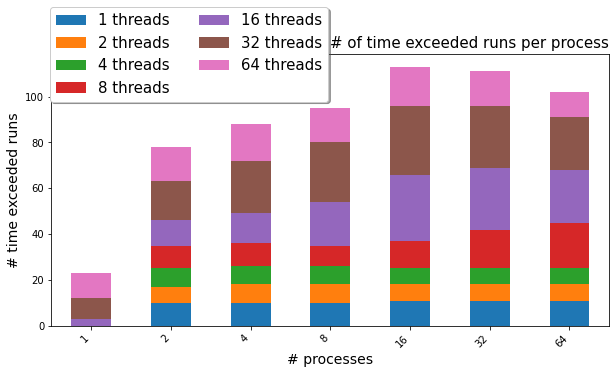

In [305]:
plt.rc('legend',fontsize=15)
fig, ax = plt.subplots(1, figsize=(10, 5))

failed_table.plot(
    x='Processes',
    y=list(filter(lambda x: 'threads' in x,list(failed_table.columns))),
    kind='bar',
    ax=ax,
    stacked=True
)
ax.set_xlabel('# processes', fontsize=14)
ax.set_ylabel('# time exceeded runs', fontsize=14)
ax.set_title('# of time exceeded runs per process', fontsize=15, loc='right')
ax.legend(loc='upper right', bbox_to_anchor=(0.51, 1.2),
          ncol=2, fancybox=True, shadow=True)
plt.xticks(rotation=45, ha='right')
plt.savefig('../report/images/number_of_failed_runs_per_process.pdf')
plt.show()

## Time exceed per thread

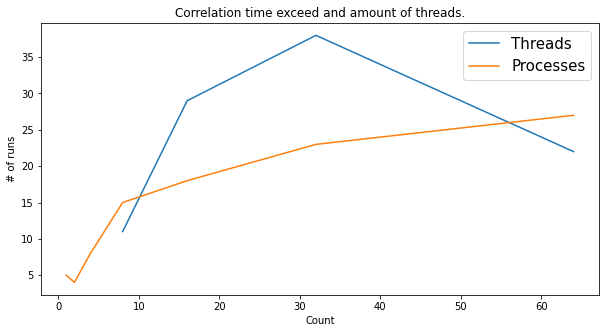

In [50]:
pack = 1

fig, ax = plt.subplots(1, figsize=(10, 5))
time_exceed = runs[
    (runs.external_time_samu == -1) & (runs.external_time_fede == -1) & (runs.packs == pack)
].groupby('threads').count()[['id']].rename(columns={'id':'Threads'})
time_exceed.plot(ax=ax)
time_exceed = runs[
    (runs.external_time_samu == -1) & (runs.external_time_fede == -1) & (runs.packs == pack)
].groupby('processes').count()[['id']].rename(columns={'id':'Processes'})
time_exceed.plot(ax=ax)
ax.set_title('Correlation time exceed and amount of threads.')
ax.set_xlabel('Count')
ax.set_ylabel('# of runs')
plt.show()

##  Interrupted by us or by full home directory

In [51]:
runs.threads.unique()

array([ 1, 16,  2, 32,  4, 64,  8])

## Correlation threads time exceed in one pack

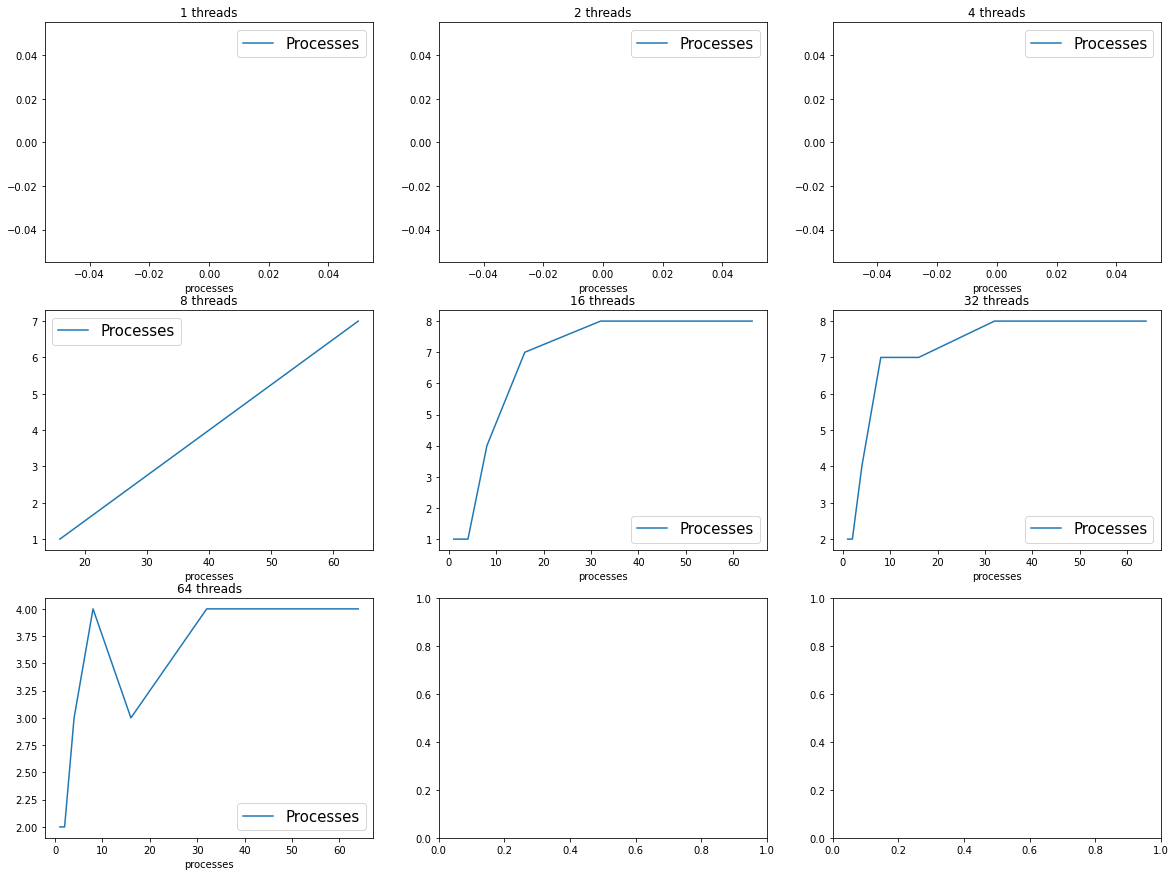

In [52]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, t in enumerate(sorted(list(runs.threads.unique()))):
    r = runs[
        (runs.external_time_samu == -1)
        & (runs.external_time_fede == -1)
        & (runs.packs == 1)
        & (runs.threads == t)
    ].groupby('processes').count()[['id']].rename(columns={'id':'Processes'})
    ax=axs[i//3,i%3]
    ax.set_title(f"{t} threads")
    r.plot(ax=ax)
plt.show()

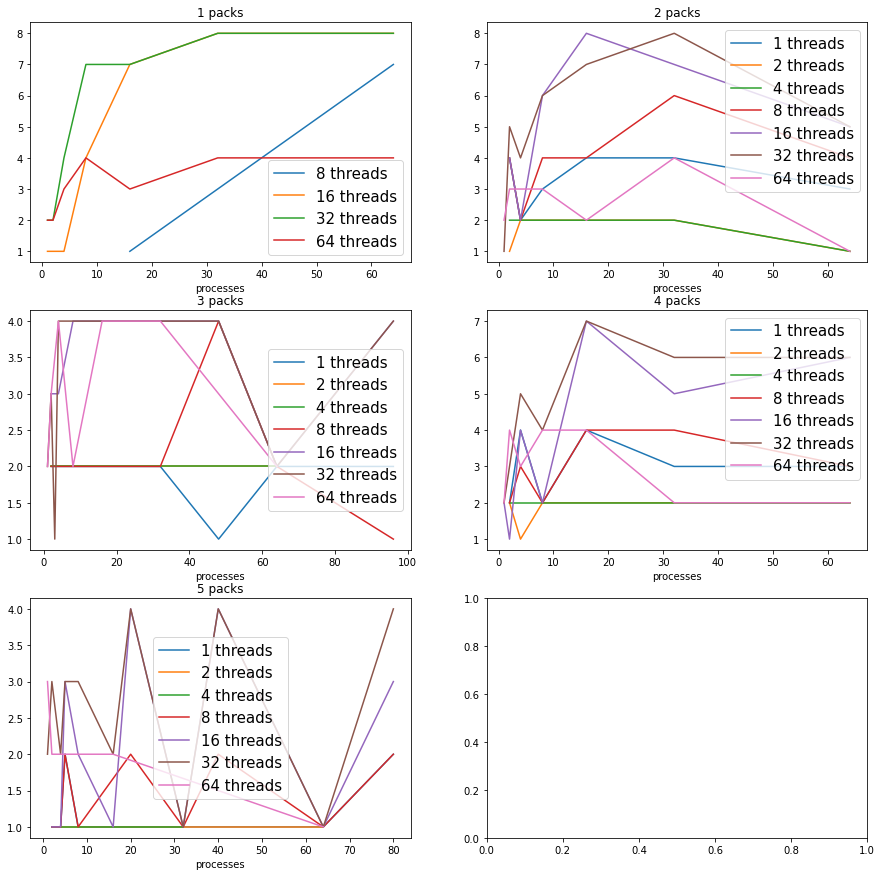

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, s in enumerate(SELECT):
    r = runs[
        (runs.external_time_samu == -1)
        & (runs.external_time_fede == -1)
        & (runs.packs == s)
    ][['threads', 'processes', 'id']].groupby(['threads', 'processes']).count()
    ax=axs[i//2,i%2]
    ax.set_title(f"{s} packs")
    for t in r.index.get_level_values(0).unique():
        r.loc[(t,)].rename(columns={'id':f'{t} threads'}).plot(ax=ax)

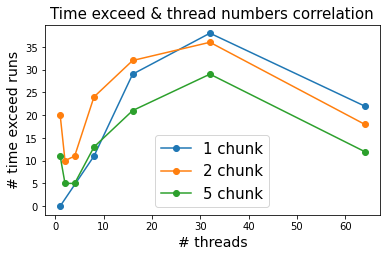

In [54]:
plt.rc('legend',fontsize=15)
fig, ax = plt.subplots(1, figsize=(6, 3.5))
for s in [1, 2, 5]:
    r = runs[
        (runs.external_time_samu == -1)
        & (runs.external_time_fede == -1)
        & (runs.packs == s)
    ][['threads','id']].groupby(['threads']).count().rename(columns={'id':f'{s} chunk'})
    for t in THREADS:
        if t not in r.index:
            r.loc[t] = 0
    r.sort_index(inplace=True)
    r.plot(ax=ax, marker='o')
ax.set_xlabel('# threads', fontsize=14)
ax.set_ylabel('# time exceed runs', fontsize=14)
ax.set_title('Time exceed & thread numbers correlation', fontsize=15)
plt.savefig('../report/images/time_threads_correlation.pdf')
plt.show()

In [55]:
runs_fede = runs_fede.dropna()
runs_samu = runs_samu.dropna()
runs = runs_fede.merge(
    runs_samu,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs['internal_time'] = runs.apply(mean_time, axis=1)
runs['processes'] = runs.id.apply(lambda x: int(x.split("--")[0]))
runs['threads'] = runs.id.apply(lambda x: int(x.split("--")[1]))
runs['place'] = runs.id.apply(lambda x: x.split("--")[2])
runs['packs'] = runs.id.apply(lambda x: int(x.split("--")[3]))
len(runs)

396

In [57]:
runs_fede_second = runs_fede_second.dropna()
runs_samu_second = runs_samu_second.dropna()
runs_second = runs_fede_second.merge(
    runs_samu_second,
    how='outer',
    left_on='id',
    right_on='id',
    suffixes=('_fede', '_samu'),
)
runs_second['internal_time'] = runs_second.apply(mean_time, axis=1)
runs_second['processes'] = runs_second.id.apply(lambda x: int(x.split("--")[0]))
runs_second['threads'] = runs_second.id.apply(lambda x: int(x.split("--")[1]))
runs_second['place'] = runs_second.id.apply(lambda x: x.split("--")[2])
runs_second['packs'] = runs_second.id.apply(lambda x: int(x.split("--")[3]))
len(runs_second)

139

In [58]:
runs = pd.concat([runs, runs_second])
len(runs)

535

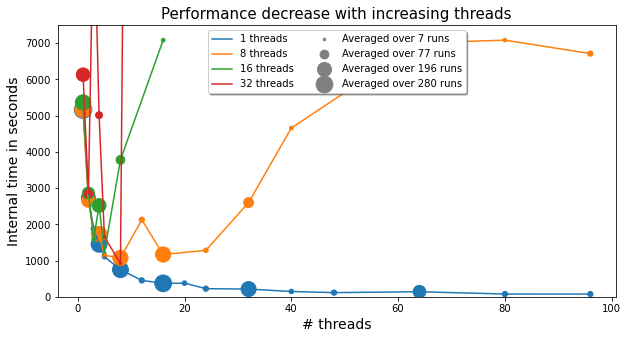

In [62]:
plt.rc('legend',fontsize=10)
fig, ax = plt.subplots(1, figsize=(10, 5))


total_sizes = []
for t in THREADS:
    A =runs[runs.threads == t][[
        'processes', 'internal_time_fede'
    ]].rename(columns={'internal_time_fede':'internal_time'})
    B =runs[runs.threads == t][[
        'processes', 'internal_time_samu'
    ]].rename(columns={'internal_time_samu':'internal_time'})
    exclusive_analysis = pd.concat([A,B])
    exclusive_analysis = exclusive_analysis.sort_values('internal_time', ascending=False)
    mean_table = exclusive_analysis.groupby('processes').agg(['mean', 'count'])
    mean_table.rename(columns={
        'internal_time': f'{t} threads'
    },inplace=True)
    mean = mean_table[(f'{t} threads', 'mean')].values
    sizes = mean_table[(f'{t} threads', 'count')].values * 7
    total_sizes.append(sizes)
    processes = mean_table.index.values
    ax.plot(processes, mean, label=f'{t} threads')
    ax.scatter(processes, mean, s=sizes, marker='o')
total_sizes = np.unique(np.concatenate(total_sizes))
total_sizes.sort()
legend_sizes = total_sizes[::(len(total_sizes)//4)+1]
for l in legend_sizes:
    plt.scatter([],[], s=l,label=f"Averaged over {l} runs", c='grey')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=2, fancybox=True, shadow=True)
ax.set_xlabel('# threads', fontsize=14)
ax.set_ylabel('Internal time in seconds', fontsize=14)
ax.set_ylim([0, 7500])
ax.set_title('Performance decrease with increasing threads', fontsize=15)
plt.savefig('../report/images/threads_performance.pdf')
plt.show()

## Exclusive or not exclusive?

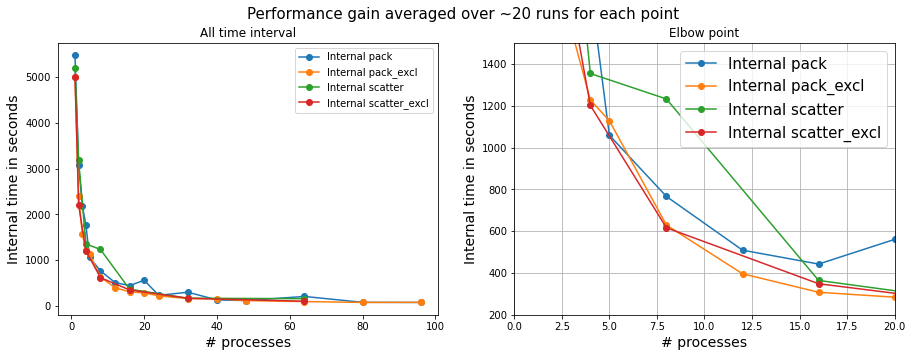

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

second = False
for ax in axs: 
    A =runs[runs.threads == 1][[
        'processes', 'place', 'external_time_fede', 'internal_time_fede'
    ]].rename(columns={'external_time_fede':'external_time', 'internal_time_fede':'internal_time'})
    B =runs[runs.threads == 1][[
        'processes', 'place', 'external_time_samu', 'internal_time_samu'
    ]].rename(columns={'external_time_samu':'external_time', 'internal_time_samu':'internal_time'})
    for p in ['pack', 'pack_excl', 'scatter', 'scatter_excl']:
        exclusive_analysis = pd.concat([A,B])
        exclusive_analysis = exclusive_analysis[exclusive_analysis.place == p].drop(columns=['place'])
        exclusive_analysis = exclusive_analysis.sort_values('internal_time', ascending=False)
        mean_table = exclusive_analysis.groupby('processes').mean()
        mean_table.rename(columns={
            'external_time': f'External {p}',
            'internal_time': f'Internal {p}'
        },inplace=True)
        mean_table.drop(columns=f'External {p}', inplace=True)
        mean_table.plot(ax=ax, marker='o')
    plt.rc('legend',fontsize=15)
    ax.set_xlabel('# processes', fontsize=14)
    ax.set_ylabel('Internal time in seconds', fontsize=14)
    if second:
        ax.set_ylim([200, 1500])
        ax.set_xlim([0, 20])
        ax.grid()
        ax.set_title('Elbow point')
    else:
        ax.set_title('All time interval')
        
    second = True
    
fig.suptitle('Performance gain averaged over ~20 runs for each point', fontsize=15)
plt.savefig('../report/images/processes_performance.pdf')
plt.show()

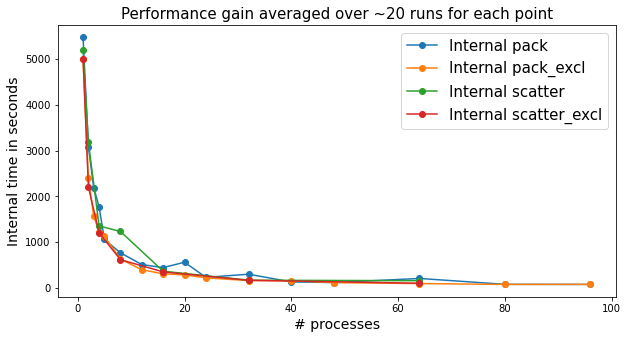

In [64]:
fig, ax = plt.subplots(1, figsize=(10, 5))

A =runs[runs.threads == 1][[
    'processes', 'place', 'external_time_fede', 'internal_time_fede'
]].rename(columns={'external_time_fede':'external_time', 'internal_time_fede':'internal_time'})
B =runs[runs.threads == 1][[
    'processes', 'place', 'external_time_samu', 'internal_time_samu'
]].rename(columns={'external_time_samu':'external_time', 'internal_time_samu':'internal_time'})
for p in ['pack', 'pack_excl', 'scatter', 'scatter_excl']:
    exclusive_analysis = pd.concat([A,B])
    exclusive_analysis = exclusive_analysis[exclusive_analysis.place == p].drop(columns=['place'])
    exclusive_analysis = exclusive_analysis.sort_values('internal_time', ascending=False)
    mean_table = exclusive_analysis.groupby('processes').mean()
    mean_table.rename(columns={
        'external_time': f'External {p}',
        'internal_time': f'Internal {p}'
    },inplace=True)
    mean_table.drop(columns=f'External {p}', inplace=True)
    mean_table.plot(ax=ax, marker='o')
plt.rc('legend',fontsize=15)
ax.set_xlabel('# processes', fontsize=14)
ax.set_ylabel('Internal time in seconds', fontsize=14)
plt.title('Performance gain averaged over ~20 runs for each point', fontsize=15)
plt.savefig('../report/images/processes_performance_short_report.pdf')
plt.show()

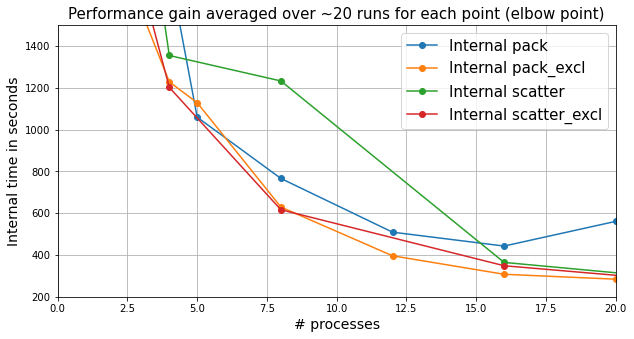

In [65]:
fig, ax = plt.subplots(1, figsize=(10, 5))

A =runs[runs.threads == 1][[
    'processes', 'place', 'external_time_fede', 'internal_time_fede'
]].rename(columns={'external_time_fede':'external_time', 'internal_time_fede':'internal_time'})
B =runs[runs.threads == 1][[
    'processes', 'place', 'external_time_samu', 'internal_time_samu'
]].rename(columns={'external_time_samu':'external_time', 'internal_time_samu':'internal_time'})
for p in ['pack', 'pack_excl', 'scatter', 'scatter_excl']:
    exclusive_analysis = pd.concat([A,B])
    exclusive_analysis = exclusive_analysis[exclusive_analysis.place == p].drop(columns=['place'])
    exclusive_analysis = exclusive_analysis.sort_values('internal_time', ascending=False)
    mean_table = exclusive_analysis.groupby('processes').mean()
    mean_table.rename(columns={
        'external_time': f'External {p}',
        'internal_time': f'Internal {p}'
    },inplace=True)
    mean_table.drop(columns=f'External {p}', inplace=True)
    mean_table.plot(ax=ax, marker='o')
plt.rc('legend',fontsize=15)
ax.set_xlabel('# processes', fontsize=14)
ax.set_ylabel('Internal time in seconds', fontsize=14)
ax.set_ylim([200, 1500])
ax.set_xlim([0, 20])
ax.grid()
plt.title('Performance gain averaged over ~20 runs for each point (elbow point)', fontsize=15)
plt.savefig('../report/images/processes_performance_elbow_short_report.pdf')
plt.show()

/tmp/ipykernel_9166/3428871308.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r = exclusive_analysis[runs.packs == s]
/tmp/ipykernel_9166/3428871308.py:3: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  r = exclusive_analysis[runs.packs == s]


ValueError: cannot reindex on an axis with duplicate labels

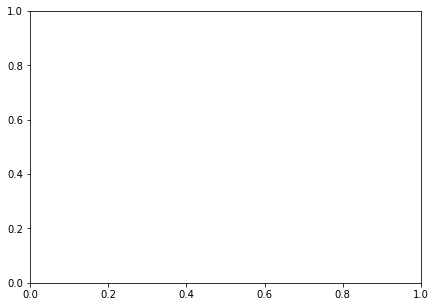

In [66]:
fig, ax = plt.subplots(1, figsize=(7, 5))
for s in [1, 2, 3, 4, 5]:
    r = exclusive_analysis[runs.packs == s]
    for p in PLACES:
        r.plot(r[r.place == p],ax=ax)
    r.sort_index(inplace=True)
plt.rc('legend',fontsize=15)
ax.set_xlabel('# threads', fontsize=14)
ax.set_ylabel('# time exceed runs', fontsize=14)
ax.set_title('Time exceed & thread numbers correlation', fontsize=15)
#plt.savefig('../report/images/time_threads_correlation.pdf')
plt.show()

## BOH

In [14]:
# There is no consistency across different runs
len(runs[runs.fitness_fede != runs.fitness_samu]), len(runs[runs.fitness_fede == runs.fitness_samu]) 

(319, 77)

In [15]:
runs['fitness_absolute_diff'] = np.abs(runs.fitness_fede - runs.fitness_samu).fillna(0)
runs.fitness_absolute_diff

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
391    0.0
392    0.0
393    0.0
394    0.0
395    0.0
Name: fitness_absolute_diff, Length: 396, dtype: float64

In [16]:
runs.fitness_absolute_diff.mean(), max(runs.fitness_fede.max(), runs.fitness_samu.max()), min(runs.fitness_fede.min(), runs.fitness_samu.min())

(1053.0326240782827, 11338.455174, 2499.697508)

In [17]:
runs['time_absolute_diff'] = np.abs(runs.internal_time_fede - runs.internal_time_samu).fillna(0)
runs.time_absolute_diff

0        0.000000
1       90.890047
2      555.720750
3      102.735450
4      152.763305
          ...    
391      0.000000
392      0.000000
393      0.000000
394      0.000000
395      0.000000
Name: time_absolute_diff, Length: 396, dtype: float64

In [18]:
runs.time_absolute_diff.mean(), max(runs.internal_time_fede.max(), runs.internal_time_samu.max()), min(runs.internal_time_fede.min(), runs.internal_time_samu.min())

(377.19456440514523, 24966.224556, 79.11064218750003)

In [19]:
runs.internal_time_fede.mean() / 60

41.78937707253567

In [20]:
runs['total'] = runs.processes * runs.packs
runs[runs.total >= 90]

,fitness_fede,internal_time_fede,external_time_fede,id,fitness_samu,internal_time_samu,external_time_samu,internal_time,processes,threads,place,packs,fitness_absolute_diff,time_absolute_diff,total
215,4307.510438,161.425060,171.796,32--1--pack--3,4307.510438,161.847242,176.180,161.636151,32,1,pack,3,0.000000,0.422181,96
218,4307.510438,161.858728,173.243,32--1--pack_excl--3,4307.510438,161.008513,174.372,161.433621,32,1,pack_excl,3,0.000000,0.850214,96
223,9239.756855,161.425200,172.021,32--2--pack--3,5368.514239,161.976487,173.075,161.700844,32,2,pack,3,3871.242616,0.551287,96
226,6588.665859,161.427331,173.127,32--2--pack_excl--3,6274.592049,161.538376,175.653,161.482854,32,2,pack_excl,3,314.073810,0.111045,96
230,5673.998215,168.162437,177.720,32--4--pack--3,6931.234932,168.133286,181.123,168.147861,32,4,pack,3,1257.236717,0.029151,96
233,7276.183002,168.312806,180.275,32--4--pack_excl--3,8174.067548,168.139727,182.168,168.226267,32,4,pack_excl,3,897.884546,0.173079,96
237,7383.764233,537.199645,548.476,32--8--pack--3,9142.518028,540.912572,551.139,539.056108,32,8,pack,3,1758.753795,3.712927,96
238,3999.495415,547.924488,560.363,32--8--pack_excl--3,7867.844341,538.179921,550.119,543.052204,32,8,pack_excl,3,3868.348926,9.744567,96


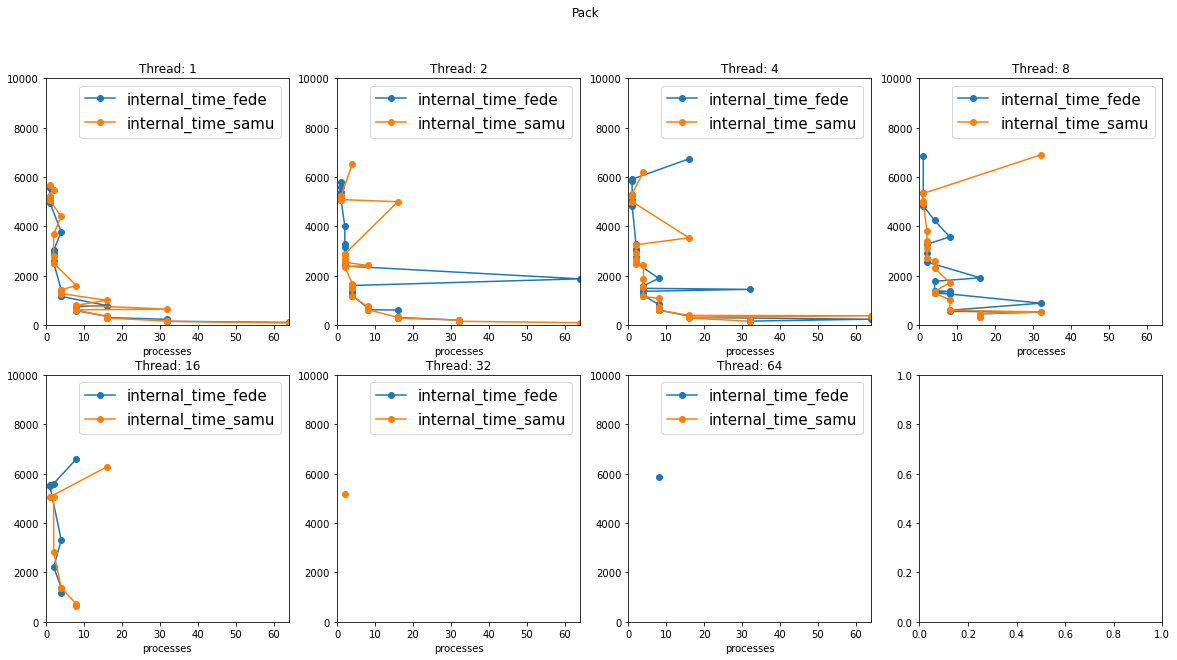

In [21]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('Pack')
plt.savefig('pack.png')
plt.show()

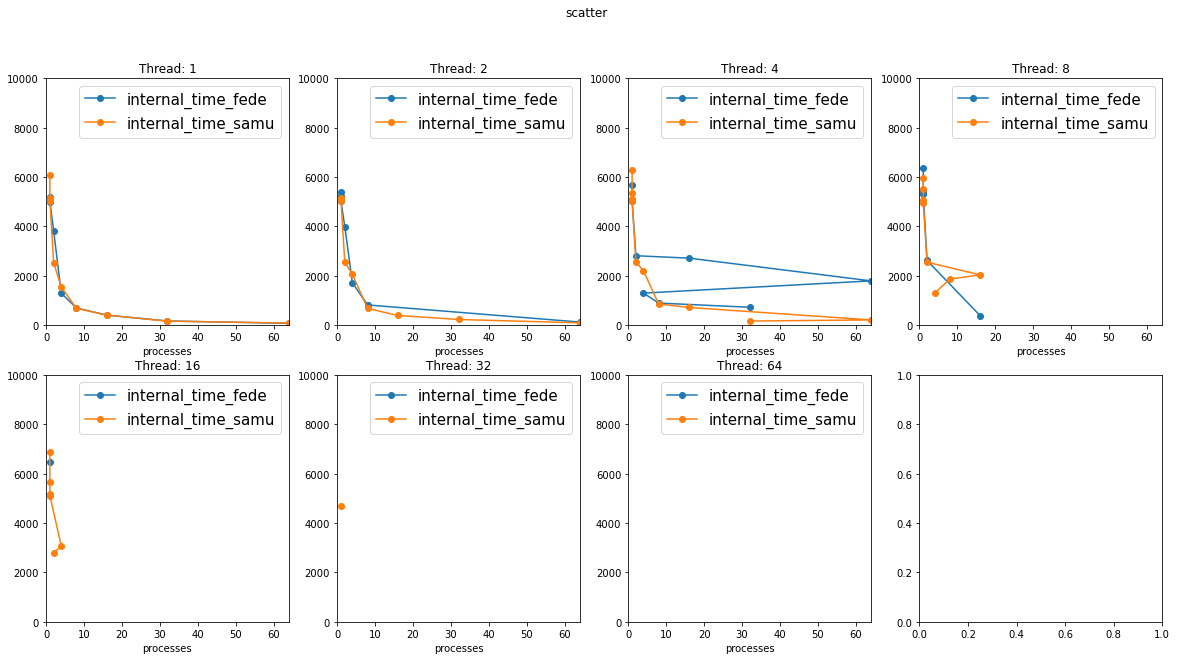

In [22]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('scatter')
plt.savefig('scatter.png')
plt.show()

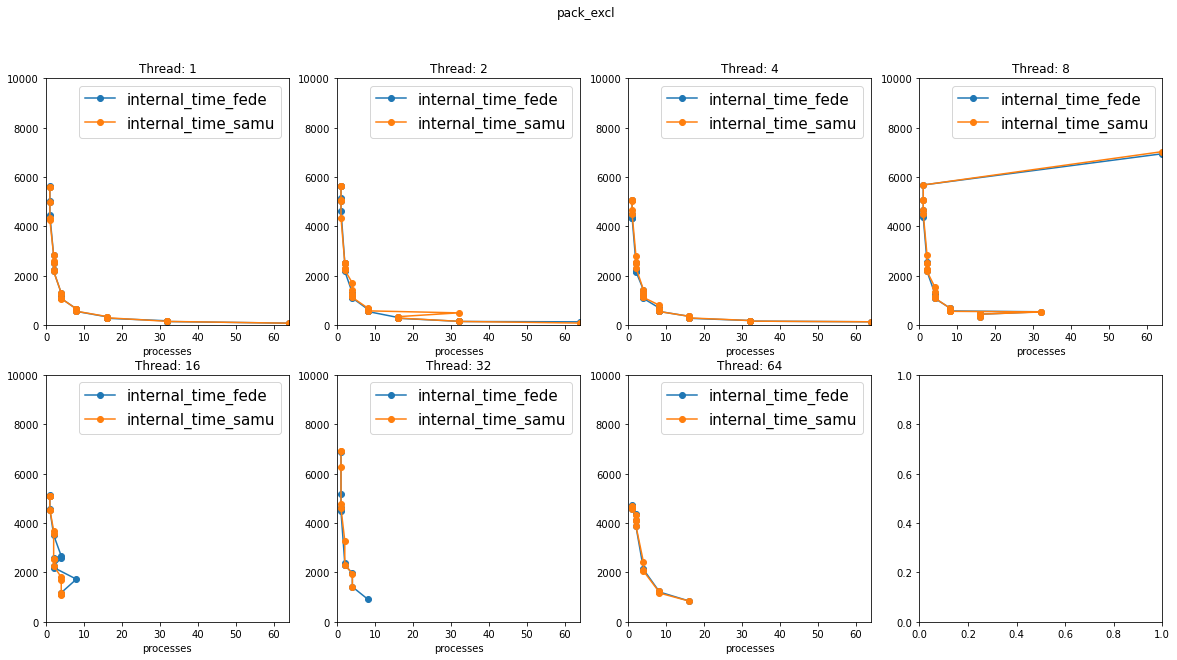

In [23]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'pack_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('pack_excl')
plt.savefig('pack_excl.png')
plt.show()

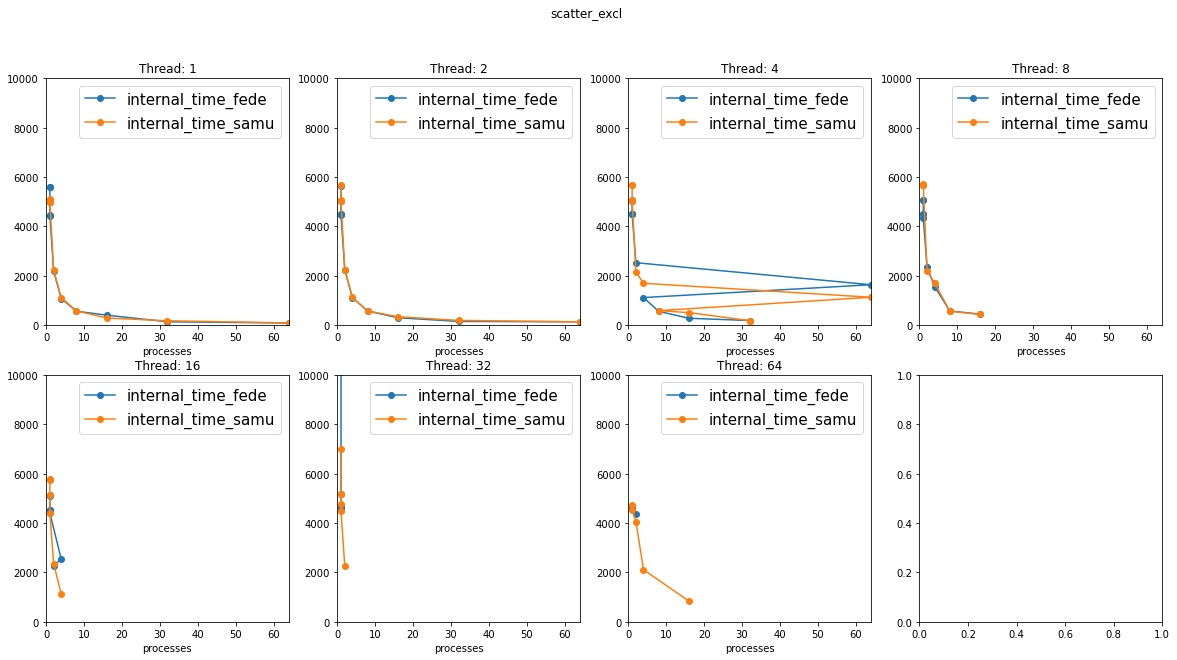

In [24]:
fig, axs = plt.subplots(2,4, figsize=(20, 10))
for i, t in zip(range(4), [1,2,4,8]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[0, i])
    axs[0, i].set_title(f"Thread: {t}")
    axs[0, i].set_xlim([0, 64])
    axs[0, i].set_ylim([0, 10000])
for i, t in zip(range(3), [16, 32, 64]):
    for s in ['fede', 'samu']:
        runs[(runs.place == 'scatter_excl') & (runs.threads == t)].sort_values(f'internal_time_{s}').plot(x='processes', y=f'internal_time_{s}', marker='o', ax=axs[1, i])
    axs[1, i].set_title(f"Thread: {t}")
    axs[1, i].set_xlim([0, 64])
    axs[1, i].set_ylim([0, 10000])

plt.suptitle('scatter_excl')
plt.savefig('scatter_excl.png')
plt.show()